In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import PIL
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from model.model import UNet, Conv1x1, GaussNet, ProbUNet
import vis_and_data_utils.visualization_utils as visualization_utils
from train_utils import get_id_to_train_id, get_segmentation_variant

In [10]:
from train_utils import create_possible_segm_with_probs, get_segmentation_variant, get_energy_distance

In [5]:
num_classes = 24
batch_size = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_root = "/home/glazkova/ProbabilisticUnet/data"
id_to_train_id = get_id_to_train_id()

img_transform_func = transforms.Compose([
                        transforms.Resize((256, 512), interpolation = PIL.Image.BILINEAR),
                        transforms.ToTensor(),

                    ])

labels_transform_func = transforms.Compose([
                        transforms.Resize((256, 512), interpolation = PIL.Image.NEAREST),
                        transforms.Lambda(lambda x: id_to_train_id[x]),
                        transforms.ToTensor()
                    ])

test_dataset = datasets.Cityscapes(root=data_root, 
                           mode="fine",
                           split="val",
                           target_type="semantic",
                           transform = img_transform_func,
                           target_transform = labels_transform_func)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size)

In [16]:
s = test_dataset[124][1].squeeze()

In [17]:
res, probs = create_possible_segm_with_probs(s)

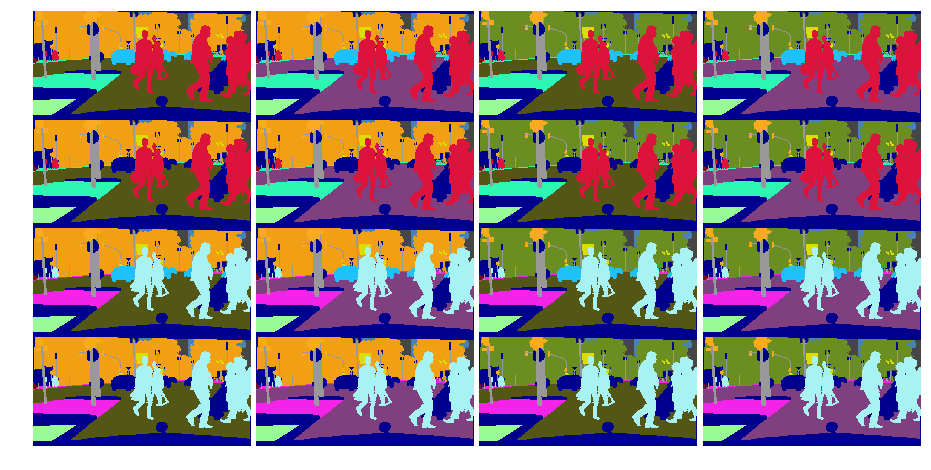

In [20]:
from matplotlib import gridspec

cmap = visualization_utils.get_color_map()

cols = 4
rows = 8

fig = plt.figure(figsize=(cols * 4, rows * 2))
gs = gridspec.GridSpec(rows, cols, wspace=0.0, hspace=0.0)

for img_num in range(8,24):
    ax = plt.subplot(gs[img_num // cols,img_num % cols])
    ax.axis('off')
    ax.imshow(visualization_utils.seg_to_rgb(res[img_num], cmap)) 
    
plt.savefig("flipping_ex.jpg")
plt.show()

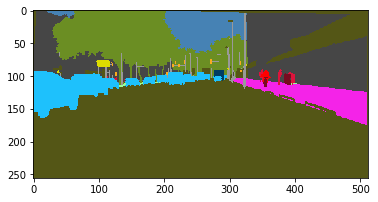

In [79]:
for i in range(10):
    plt.imshow(visualization_utils.seg_to_rgb(get_segmentation_variant(s), cmap))

In [ ]:
def count_switchable_class(segm_1, segm_2):
    """
    Params:
        segm_1, segm_2 - two segmantations for the same image
    Result:
        numpy array of size (5,3) for each switchable class count for pixels
        (original class on the first, original class on second the image, alternative class on the second image)
    """
    switch_from_names = visualization_utils.label_switches.keys()
    switch_from_ids = [visualization_utils.name2train_id[name] for name in switch_from_names]
    switch_to_ids = [visualization_utils.switched_name2train_id[name + "_2"] for name in switch_from_names]
    
    res = np.array(5,3)
    for ind, label_id in enumerate(switch_from_ids):
        res[ind][0] = np.sum(segm_1 == label_id)
        res[ind][1] = np.sum(segm_2 == label_id)
        res[ind][1] = np.sum(segm_2 == switch_to_ids[ind])
    return res